# 回帰分析のベースライン

1. ライブラリのインポート

In [35]:
# 前処理に必要なライブラリ
import numpy as np
import pandas as pd
import re
import pickle
import gc
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, train_test_split

# 警告を無視
import warnings
warnings.filterwarnings("ignore")

import joblib

In [2]:
#  機械学習モデルのインポート
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [29]:
# dataの読み込み
train_df = pd.read_csv(r"C:\data\kaggle_Open_Polymer_2025\train_df_with_descriptors.csv")

In [30]:
train_df.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SMILES_len,num_C,num_O,num_N
0,87817.0,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,0.932,NaN,12.144536,12.144536,0.105927,...,0,0,0,0,3,0,26,9,2,0
1,106919.0,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,3.523412,3.523412,0.098918,...,0,0,0,0,2,0,82,19,0,2
2,388772.0,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,13.714745,13.714745,0.107441,...,0,0,0,0,0,0,134,14,9,0
3,519416.0,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,3.978671,3.978671,0.054569,...,0,0,0,0,0,0,79,4,0,2
4,539187.0,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,13.703218,13.703218,0.068062,...,0,0,0,0,12,0,118,30,12,4


データの前処理

In [31]:
# 各目的変数の非欠損のインデックスを取得
tg_idx = train_df.loc[train_df["Tg"].notna()].index

# 目的変数を定義
tg_train = train_df["Tg"].iloc[tg_idx]

# 説明変数を定義
X_tg_train = train_df.iloc[tg_idx].iloc[:, 7:]

# データの確認
X_tg_train.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SMILES_len,num_C,num_O,num_N
40,11.248449,11.248449,0.023312,-0.334079,0.435492,13.615385,185.183,174.095,185.080041,72,...,0,0,0,0,0,0,26,7,3,3
57,2.142025,2.142025,0.580086,0.580086,0.318231,12.571429,268.538,248.378,268.044785,84,...,0,0,0,0,4,0,16,10,0,0
63,2.408148,2.408148,0.540428,0.540428,0.448030,13.600000,138.254,120.110,138.140851,58,...,0,0,0,0,6,0,13,10,0,0
108,12.365137,12.365137,0.240279,-0.478718,0.243344,11.111111,494.588,460.316,494.241687,192,...,0,0,0,0,7,0,58,16,6,2
123,6.354825,6.354825,0.021602,-0.021602,0.202350,12.312500,466.672,436.432,466.174870,168,...,0,2,0,0,6,0,49,12,2,0


In [34]:
len(tg_train) == len(X_tg_train)


True

モデル学習

In [11]:
def compare_models_cv(input_x, input_y, n = 5):
    # モデル定義
    models_to_compare = {
        'RandomForest': lambda: RandomForestRegressor(),
        'ExtraTrees': lambda: ExtraTreesRegressor(),
        'XGBoost': lambda: XGBRegressor(verbosity=0),
        'LightGBM': lambda: LGBMRegressor(verbose=-1),
        'CatBoost': lambda: CatBoostRegressor(verbose=0),
    }

    # 評価指標を格納するリスト
    results = []

    # 5-fold クロスバリデーション
    kf = KFold(n_splits=n, shuffle=True, random_state=42)

    for model_name, model_func in models_to_compare.items():
        r2_scores = []
        mae_scores = []
        rmse_scores = []

        for train_idx, valid_idx in kf.split(input_x):
            X_train, X_valid = input_x.iloc[train_idx], input_x.iloc[valid_idx]
            y_train, y_valid = input_y.iloc[train_idx], input_y.iloc[valid_idx]

            model = model_func()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)

            r2_scores.append(r2_score(y_valid, y_pred))
            mae_scores.append(mean_absolute_error(y_valid, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y_valid, y_pred)))

        results.append({
            "Model": model_name,
            "R2": np.mean(r2_scores),
            "MAE": np.mean(mae_scores),
            "RMSE": np.mean(rmse_scores)
        })

    # データフレームとして出力
    result_df = pd.DataFrame(results)
    print(result_df)
    return result_df

In [36]:
tg_result = compare_models_cv(X_tg_train, tg_train)

          Model        R2        MAE       RMSE
0  RandomForest  0.799900  39.048561  54.959380
1    ExtraTrees  0.800942  37.965325  54.811878
2       XGBoost  0.780117  40.135570  57.504270
3      LightGBM  0.810771  37.830944  53.420127
4      CatBoost  0.820064  36.831984  52.126639


最もスコアがよいCatBoostで詳細に出力

In [40]:
def run_catboost_cv(input_x, input_y, n=5):
    kf = KFold(n_splits=n, shuffle=True, random_state=42)
    oof_pred = np.zeros(len(input_y))
    models = []

    importances = np.zeros(input_x.shape[1])
    r2_list, mae_list, rmse_list = [], [], []

    for train_idx, valid_idx in kf.split(input_x):
        X_train, X_valid = input_x.iloc[train_idx], input_x.iloc[valid_idx]
        y_train, y_valid = input_y.iloc[train_idx], input_y.iloc[valid_idx]

        model = CatBoostRegressor(verbose=0, random_state=42)
        model.fit(X_train, y_train)
        pred = model.predict(X_valid)
        models.append(model)

        oof_pred[valid_idx] = pred
        importances += model.get_feature_importance()

        r2_list.append(r2_score(y_valid, pred))
        mae_list.append(mean_absolute_error(y_valid, pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_valid, pred)))

    metric = {
        "R2": np.mean(r2_list),
        "MAE": np.mean(mae_list),
        "RMSE": np.mean(rmse_list)
    }

    importance_df = pd.DataFrame({
        "feature": input_x.columns,
        "importance": importances / n
    }).sort_values(by="importance", ascending=False)
    
    #最終モデルを全データで学習
    final_model = CatBoostRegressor(verbose=0, random_state=42)
    final_model.fit(input_x, input_y)

    return final_model, metric, importance_df, oof_pred

In [41]:
model_tg, metric_tg, imp_tg, oof_tg = run_catboost_cv(X_tg_train, tg_train)

In [42]:
metric_tg

{'R2': 0.8159144824713158,
 'MAE': 37.17341481823574,
 'RMSE': 52.733969503599745}

In [43]:
imp_tg.head()

,feature,importance
103,FractionCSP3,4.848620
127,RingCount,4.472059
19,BCUT2D_MWLOW,4.400007
120,NumRotatableBonds,3.413761
23,BCUT2D_LOGPLOW,3.101732


In [44]:
def evaluate_and_plot(tg_train, oof_preds_tg, figsize=(4, 4)):
    """
    トレーニングデータの予測性能を評価し、実測値 vs. 推定値のプロットを表示する関数。

    Parameters:
    - tg_train: 実測値 (array-like)
    - oof_preds_tg: 推定値 (array-like)
    - figsize: プロット図のサイズ (tuple, default: (4, 4))
    """

    # 評価指標の出力
    print('r^2 for training data :', r2_score(tg_train, oof_preds_tg))
    print('RMSE for training data :', np.sqrt(mean_squared_error(tg_train, oof_preds_tg)))
    print('MAE for training data :', mean_absolute_error(tg_train, oof_preds_tg))

    # 実測値 vs. 推定値のプロット
    plt.figure(figsize=figsize)
    plt.scatter(tg_train, oof_preds_tg, c='blue')

    y_max = max(tg_train.max(), oof_preds_tg.max())
    y_min = min(tg_train.min(), oof_preds_tg.min())

    buffer = 0.05 * (y_max - y_min)
    plt.plot([y_min - buffer, y_max + buffer],
             [y_min - buffer, y_max + buffer], 'k-')
    plt.xlim(y_min - buffer, y_max + buffer)
    plt.ylim(y_min - buffer, y_max + buffer)

    plt.xlabel('actual y')
    plt.ylabel('estimated y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

r^2 for training data : 0.8151941752758517
RMSE for training data : 52.94363257579299
MAE for training data : 37.17261245711484


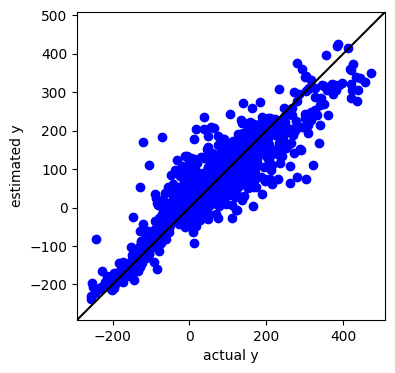

In [45]:
evaluate_and_plot(tg_train, oof_tg)

In [46]:
# モデルを保存
joblib.dump(model_tg, "model_tg.pkl")

# モデルを読み込み
model_tg_loaded = joblib.load("model_tg.pkl")

In [ ]:
# 作成したモデルを用いて、test_dataを予測
tg_preds = model_tg_loaded.predict(tg_test)

In [47]:
!jupyter nbconvert --to html Base_Line_Regression.ipynb

[NbConvertApp] Converting notebook Base_Line_Regression.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 344028 bytes to Base_Line_Regression.html
